In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

# outliers

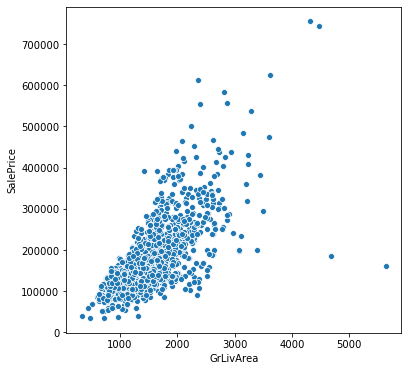

In [4]:
# we must be careful while dropping the outliers of the risk of loosing valuable information
plt.figure(figsize = (6,6))
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train)
#we observe tow outliers where the price is very low for two houses given a large living area
#this observation do not align with the data and this are bad deals if there are this type of outliers in our data 
#we may get extra bias as the line will try to fit this two outliers

In [5]:
#lets drop this outliers
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 20000)].index).reset_index(drop = True)

# numerical to categorical conversion

In [240]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Encoding all categorical labels

In [140]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
categorical_feature_mask = all_data.dtypes == object
categorical_columns = all_data.columns[categorical_feature_mask].tolist()
all_data[categorical_columns] = all_data[categorical_columns].apply(lambda col : label_encoder.fit_transform(col.astype(str)))

In [141]:
all_data.dtypes

MSSubClass         int64
MSZoning           int64
LotFrontage      float64
LotArea            int64
Street             int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType           int64
SaleCondition      int64
Length: 79, dtype: object

# Normalize 

1.880940746034036

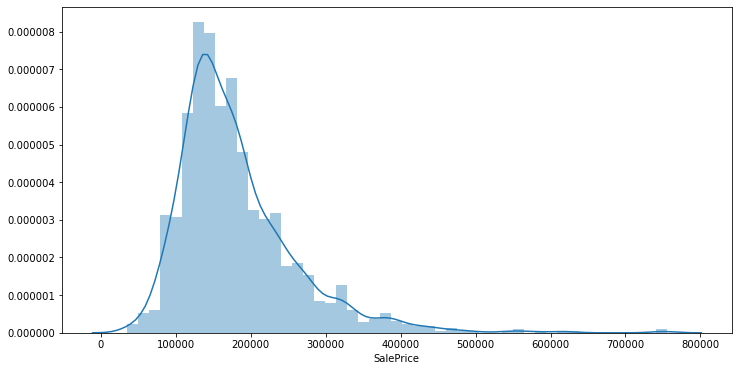

In [6]:
from scipy.stats import skew
plt.figure(figsize = (12,6))
g = sns.distplot(train['SalePrice'])
skew(train['SalePrice'])

In [7]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
train['SalePrice'] = pt.fit_transform(train['SalePrice'].values.reshape(-1,1))

In [8]:
# lets code a function that calculates skewness

In [9]:
# getting all the numeric data
numerical_features_mask = all_data.dtypes != 'object'
numerical_columns = all_data.columns[numerical_features_mask].tolist()

In [10]:
skewness_of_columns = all_data[numerical_columns].apply(lambda x : skew(x.dropna()))

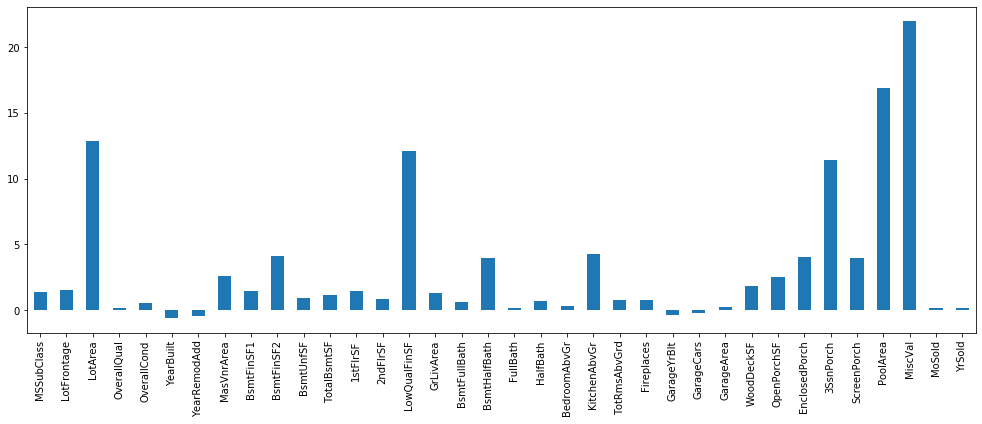

In [11]:
plt.figure(figsize = (17,6))
skewness_of_columns.plot(kind = 'bar')


In [12]:
# lets keep a limit of 0.75 for our data skewness
skewness_of_columns = skewness_of_columns[abs(skewness_of_columns) > 0.75]

In [13]:
skewness_of_columns # this are the columns with worst skewness

MSSubClass        1.375457
LotFrontage       1.502351
LotArea          12.822431
MasVnrArea        2.601240
BsmtFinSF1        1.424989
BsmtFinSF2        4.145323
BsmtUnfSF         0.919351
TotalBsmtSF       1.162285
1stFlrSF          1.469604
2ndFlrSF          0.861675
LowQualFinSF     12.088761
GrLivArea         1.269358
BsmtHalfBath      3.929996
KitchenAbvGr      4.302254
TotRmsAbvGrd      0.758367
WoodDeckSF        1.842433
OpenPorchSF       2.535114
EnclosedPorch     4.003891
3SsnPorch        11.376065
ScreenPorch       3.946694
PoolArea         16.898328
MiscVal          21.947195
dtype: float64

In [14]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
all_data[skewness_of_columns.index] = pt.fit_transform(all_data[skewness_of_columns.index])

In [15]:
skewness_of_columns_new = all_data[skewness_of_columns.index].apply(lambda x : skew(x.dropna()))

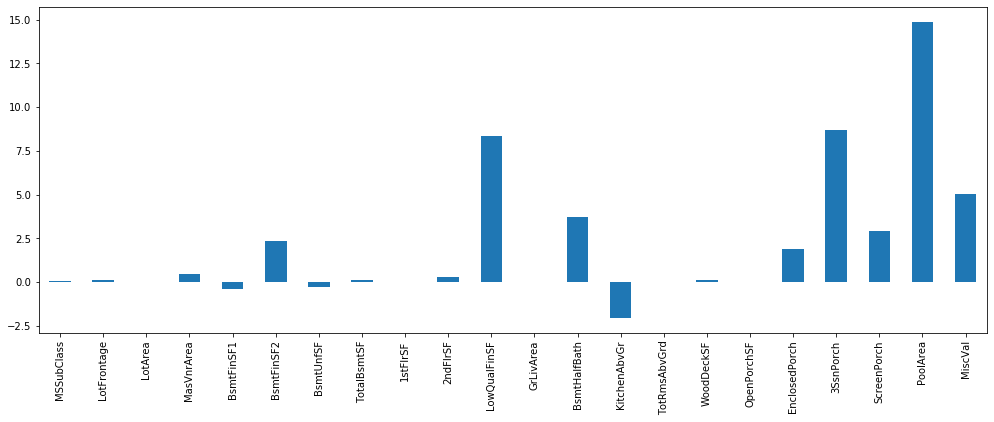

In [16]:
# after applying the skewness function
plt.figure(figsize = (17,6))
skewness_of_columns_new.plot(kind = 'bar')


In [17]:
all_data = pd.get_dummies(all_data)

In [18]:
all_data.isnull().any().any()

True

In [19]:
all_data.isnull().sum()

MSSubClass                 0
LotFrontage              486
LotArea                    0
OverallQual                0
OverallCond                0
                        ... 
SaleCondition_AdjLand      0
SaleCondition_Alloca       0
SaleCondition_Family       0
SaleCondition_Normal       0
SaleCondition_Partial      0
Length: 288, dtype: int64

In [20]:
# fill NA's with the mean of the feature
all_data = all_data.fillna(all_data.mean())

In [21]:
all_data.isnull().any().any()

False

In [22]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
linearModel = LinearRegression()
rmse = np.sqrt(-cross_val_score(linearModel,X_train,y,scoring='neg_mean_squared_error',cv=5))
print('RMSE estimate mean',rmse.mean(),'RMSE estimate standard_deviation',rmse.std())

RMSE estimate mean 3218045.952018495 RMSE estimate standard_deviation 3137525.2264520614


In [24]:
from sklearn.tree import DecisionTreeRegressor
decision_tree_regressor = DecisionTreeRegressor()
rmse = np.sqrt(-cross_val_score(decision_tree_regressor,X_train,y,scoring='neg_mean_squared_error',cv=5))
print('RMSE estimate mean',rmse.mean(),'RMSE estimate standard_deviation',rmse.std())

RMSE estimate mean 0.5565862827598276 RMSE estimate standard_deviation 0.04929829596921824


In [25]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rmse = np.sqrt(-cross_val_score(rfr,X_train,y,scoring='neg_mean_squared_error',cv=10))
print('RMSE estimate mean',rmse.mean(),'RMSE estimate standard_deviation',rmse.std())

RMSE estimate mean 0.4106584647978906 RMSE estimate standard_deviation 0.050807216293960906


In [26]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor()
rmse = np.sqrt(-cross_val_score(knr,X_train,y,scoring='neg_mean_squared_error',cv=5))
print('RMSE estimate mean',rmse.mean(),'RMSE estimate standard_deviation',rmse.std())

RMSE estimate mean 0.6681632475181658 RMSE estimate standard_deviation 0.021350995094108722


In [27]:
linearModel.fit(X_train,y)
#get largest magnitude coefficients
coef = pd.Series(linearModel.coef_,index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])

In [28]:
knr.fit(X_train,y)
#get largest magnitude coefficients
coef = pd.Series(linearModel.coef_,index = X_train.columns)
imp_coef_knr = pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])

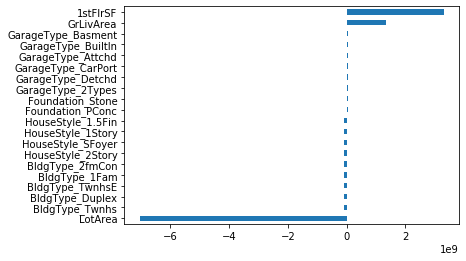

In [29]:
imp_coef.plot(kind='barh')

In [30]:
from sklearn.linear_model import Ridge
# determining ridge regression for model with alpha  = 0.1
ridgeModel = Ridge(alpha = 0.1)
rmse = np.sqrt(-cross_val_score(ridgeModel,X_train,y,scoring='neg_mean_squared_error',cv=5))
print('RMSE estimate mean',rmse.mean(),'RMSE estimate standard_deviation',rmse.std())

RMSE estimate mean 0.3874858733337679 RMSE estimate standard_deviation 0.0546257638779025


Text(0, 0.5, 'rmse')

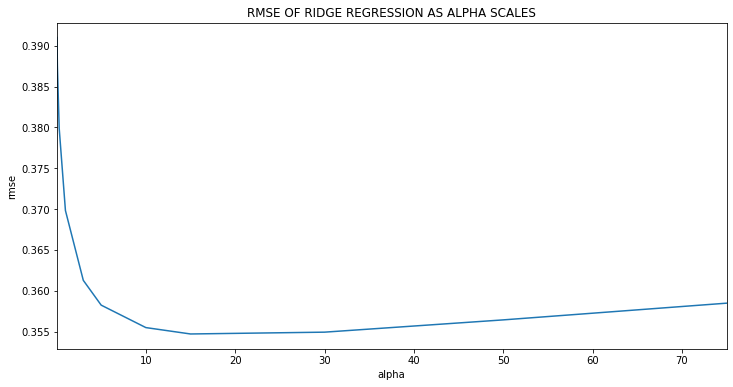

In [32]:
plt.figure(figsize = (12,6))
# calculating rmse over sevral alphas
alphas = [0.05,0.1,0.3,1,3,5,10,15,30,50,75]

#rmse_cv = np.sqrt(-cross_val_score(Ridge(alpha=alpha),X_train,y,scoring='neg_mean_squared_error',cv=5))
cv_ridge = [(np.sqrt(-cross_val_score(Ridge(alpha=alpha),X_train,y,scoring='neg_mean_squared_error',cv=5))).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge,index=alphas)

cv_ridge.plot(title = 'RMSE OF RIDGE REGRESSION AS ALPHA SCALES')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [33]:
optimalRidgeAlpha = cv_ridge[cv_ridge == cv_ridge.min()].index.values[0]
print('Best value of alpha Ridge regression is : ',optimalRidgeAlpha)

Best value of alpha Ridge regression is :  15.0


In [34]:
ridgeModel = Ridge(alpha = optimalRidgeAlpha)
rmse = (np.sqrt(-cross_val_score(ridgeModel,X_train,y,scoring='neg_mean_squared_error',cv=10))).mean()
print('RMSE for optimal ridge model is : ',rmse)

RMSE for optimal ridge model is :  0.34851725576644155


In [35]:
ridgeModel.fit(X_train,y)
ridge_coef = pd.Series(ridgeModel.coef_,X_train.columns)
ridge_imp_coef = pd.concat([ridge_coef.sort_values().head(10),ridge_coef.sort_values().tail(10)])

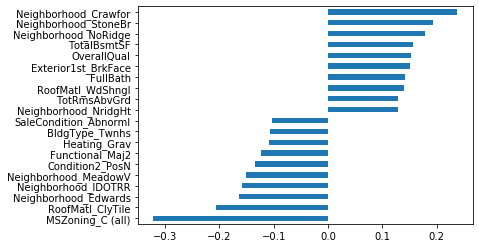

In [36]:
ridge_imp_coef.plot(kind = 'barh')

<Figure size 1296x720 with 0 Axes>

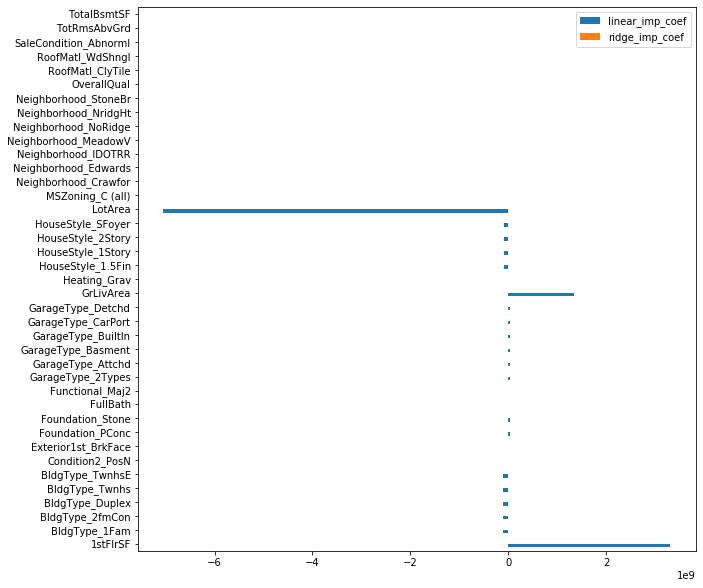

In [37]:
#lets compare linear and ridge
plt.figure(figsize = (18,10))
df = pd.DataFrame({'linear_imp_coef':imp_coef,'ridge_imp_coef':ridge_imp_coef})
df.plot(kind = 'barh',figsize = (10,10))

In [38]:
from sklearn.linear_model import Lasso
lassoModel = Lasso(alpha = 0.1)
rmse = np.sqrt(-cross_val_score(lassoModel,X_train,y,scoring='neg_mean_squared_error',cv=5)).mean()
print('RMSE LASSO MEAN',rmse)

RMSE LASSO MEAN 0.463870467286306


Text(0, 0.5, 'rmse')

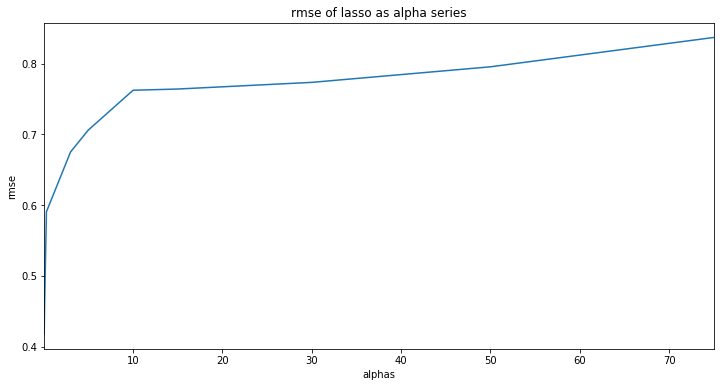

In [40]:
from sklearn.linear_model import Lasso
plt.figure(figsize = (12,6))
alphas = [0.05,0.1,0.3,3,5,10,15,30,50,75]
cv_lasso = [(np.sqrt(-cross_val_score(Lasso(alpha = alpha),X_train,y,scoring='neg_mean_squared_error',cv=10))).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso,alphas)
cv_lasso.plot(title = 'rmse of lasso as alpha series')
plt.xlabel('alphas')
plt.ylabel('rmse')

In [43]:
from sklearn.linear_model import LassoCV
lassoModel = LassoCV(alphas = np.linspace(0.0002,0.002,21),cv = 10)
lassoModel.fit(X_train,y)

LassoCV(alphas=array([0.0002 , 0.00029, 0.00038, 0.00047, 0.00056, 0.00065, 0.00074,
       0.00083, 0.00092, 0.00101, 0.0011 , 0.00119, 0.00128, 0.00137,
       0.00146, 0.00155, 0.00164, 0.00173, 0.00182, 0.00191, 0.002  ]),
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [44]:
print('The best alpha using the lasso model is:',lassoModel.alpha_)
optimal_alpha = lassoModel.alpha_

The best alpha using the lasso model is: 0.00119


In [50]:
lassoModel = Lasso(alpha = optimal_alpha)
rmse = np.sqrt(-cross_val_score(lassoModel,X_train,y,scoring='neg_mean_squared_error',cv=5)).mean()
print('RMSE LASSO MEAN',rmse)

RMSE LASSO MEAN 0.3455063439531309


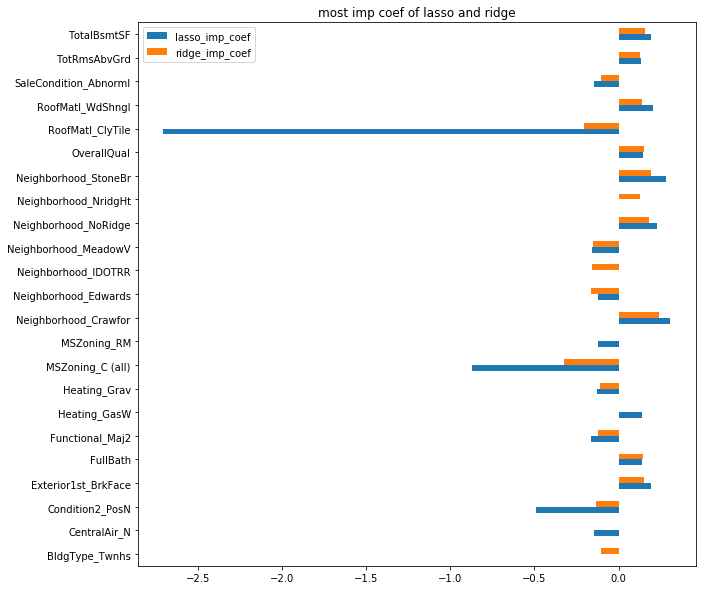

In [51]:
lassoModel.fit(X_train,y)
lasso_coef = pd.Series(lassoModel.coef_,index = X_train.columns)
lasso_imp_coef = pd.concat([lasso_coef.sort_values().head(10),lasso_coef.sort_values().tail(10)])
df = pd.DataFrame({'lasso_imp_coef':lasso_imp_coef,'ridge_imp_coef':ridge_imp_coef})
df.plot(kind = 'barh',figsize = (10,10))
plt.title('most imp coef of lasso and ridge')
plt.show()

In [54]:
lasso_coef = pd.Series(lassoModel.coef_,index = X_train.columns)
print(sum(lasso_coef == 0))
print(sum(lasso_coef != 0))

168
120


In [53]:
lasso_coef

MSSubClass              -0.012629
LotFrontage              0.037146
LotArea                  0.000000
OverallQual              0.147536
OverallCond              0.099063
                           ...   
SaleCondition_AdjLand   -0.000000
SaleCondition_Alloca     0.000000
SaleCondition_Family    -0.083263
SaleCondition_Normal     0.030033
SaleCondition_Partial    0.000000
Length: 288, dtype: float64

In [57]:
alphas = np.linspace(0.0002,0.4002,2001)
nonZeros = []
for alpha in alphas:
    lassoModel = Lasso(alpha = alpha)
    lassoModel.fit(X_train,y)
    coef = pd.Series(lassoModel.coef_,index = X_train.columns)
    nonZeros = np.append(nonZeros,sum(coef != 0))
    

Text(0, 0.5, 'number of zeros')

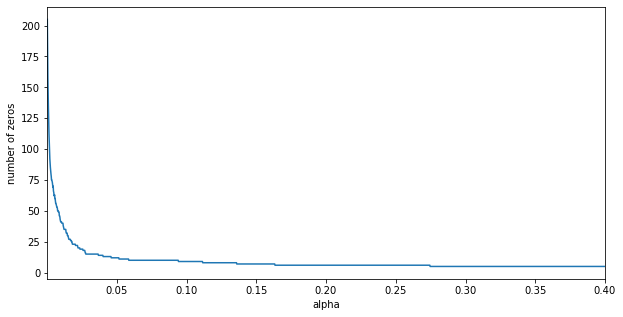

In [61]:
lzeroNorm = pd.Series(nonZeros,index = alphas)
lzeroNorm.plot(figsize = (10,10-5))
plt.xlabel('alpha')
plt.ylabel('number of zeros')